In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/sample_submission.csv
/kaggle/input/dataset/train.csv
/kaggle/input/dataset/test.csv


In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_nlp
import pandas as pd

# Example data: replace this with your dataset
data = pd.read_csv('/kaggle/input/dataset/train.csv')
data.head(5)

,SampleID,Discussion,Category
0,1,"Without sitting down and doing it manually, yo...",Sports
1,2,All your Search ends with this link.,STEM
2,3,"No, the program you're using is made to be com...",STEM
3,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,Sports
4,5,"No, but not because of why you might think. Wh...",Politics


In [96]:
data["Category"].value_counts()

Category
STEM                5530
Market & Economy    5530
Sports              5529
Politics            4200
Media               4200
Name: count, dtype: int64

In [97]:
data.isna().sum()

SampleID        0
Discussion    343
Category        0
dtype: int64

In [98]:
data.describe()

,SampleID
count,24989.000000
mean,12495.000000
std,7213.847275
min,1.000000
25%,6248.000000
50%,12495.000000
75%,18742.000000
max,24989.000000


In [99]:
data= data.dropna()

In [100]:
data["Category"]=data["Category"].map({
"Politics":0,
"Sports":1,
"Media":2,
"Market & Economy":3,
"STEM":4,
})
data.head()

,SampleID,Discussion,Category
0,1,"Without sitting down and doing it manually, yo...",1
1,2,All your Search ends with this link.,4
2,3,"No, the program you're using is made to be com...",4
3,4,Mike Woicik\n\nThe correct answer is: Mike Woi...,1
4,5,"No, but not because of why you might think. Wh...",0


In [101]:
max_words = data['Discussion'].str.split().str.len()
max_words.describe()

count    24646.000000
mean        49.919460
std         74.045042
min          1.000000
25%         13.000000
50%         29.000000
75%         54.000000
max        783.000000
Name: Discussion, dtype: float64

In [102]:
import spacy
import re

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [103]:
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters and reduce multiple spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space
    
    # Process the text with spaCy
    doc = nlp(text)
    
    # Lemmatize words and return the processed text, excluding stop words
    lemmatized_text = ' '.join(token.lemma_ for token in doc if not token.is_stop)
    
    return lemmatized_text

In [104]:
print(data["Discussion"].head())

0    Without sitting down and doing it manually, yo...
1                 All your Search ends with this link.
2    No, the program you're using is made to be com...
3    Mike Woicik\n\nThe correct answer is: Mike Woi...
4    No, but not because of why you might think. Wh...
Name: Discussion, dtype: object


In [105]:
max_words = data['Discussion'].str.split().str.len()
max_words.describe()

count    24646.000000
mean        49.919460
std         74.045042
min          1.000000
25%         13.000000
50%         29.000000
75%         54.000000
max        783.000000
Name: Discussion, dtype: float64

Most entries have a word count between 13 and 54, with the average being around 50 words.
However, there are entries with a much higher word count (up to 783), which could be considered outliers, and they might skew the average and standard deviation.
The large standard deviation indicates a significant variance in word count across entries, which suggests that some "Discussion" entries are very short while others are very long.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


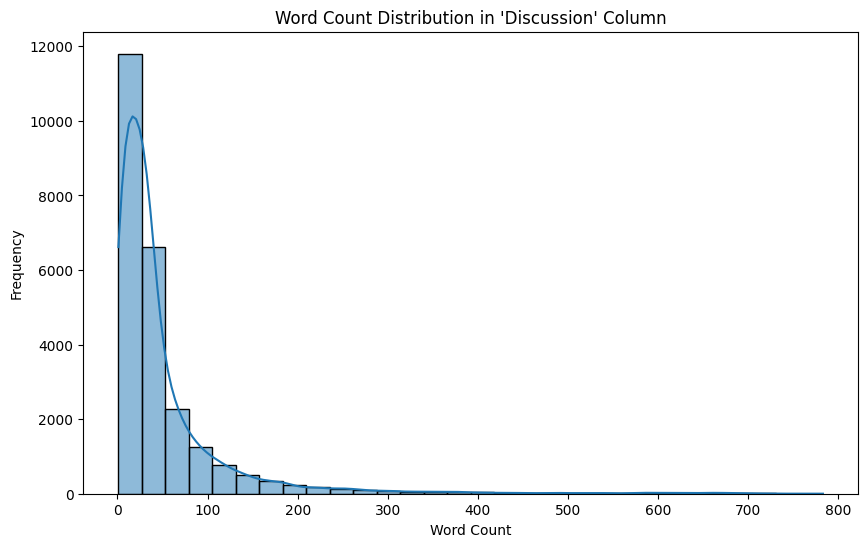

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(max_words, kde=True, bins=30)
plt.title("Word Count Distribution in 'Discussion' Column")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [107]:
data['Discussion'] = data['Discussion'].apply(preprocess)
max_words_preprocessed = data['Discussion'].str.split().str.len()
max_words_preprocessed.describe()

count    24646.000000
mean        27.305973
std         42.373290
min          0.000000
25%          7.000000
50%         16.000000
75%         28.000000
max        575.000000
Name: Discussion, dtype: float64

Even after preprocessing a similar scenarion happened where most entries have a word count between 7 and 28, with the average being around 27 words.
However, there are entries with a much higher word count (up to 575), which could be considered outliers, and they might skew the average and standard deviation.

In [108]:
# Calculate the interquartile range (IQR)
Q1 = max_words.quantile(0.25)
Q3 = max_words.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for non-outlier values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows that are considered outliers
data_filtered = data[max_words.between(lower_bound, upper_bound)]

# Check how many rows were removed
removed_rows = len(data) - len(data_filtered)
print(f"Removed {removed_rows} outliers")


Removed 2351 outliers


In [109]:
# Normalize the word count between 0 and 1
max_words_normalized = (max_words - max_words.min()) / (max_words.max() - max_words.min())

# You can now add the normalized word count back to your DataFrame if needed
data['normalized_word_count'] = max_words_normalized

In [110]:
from sklearn.preprocessing import StandardScaler

# Reshape the data for scaling
scaler = StandardScaler()
max_words_standardized = scaler.fit_transform(max_words.values.reshape(-1, 1))

# Add the standardized word count back to your DataFrame if needed
data['standardized_word_count'] = max_words_standardized

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


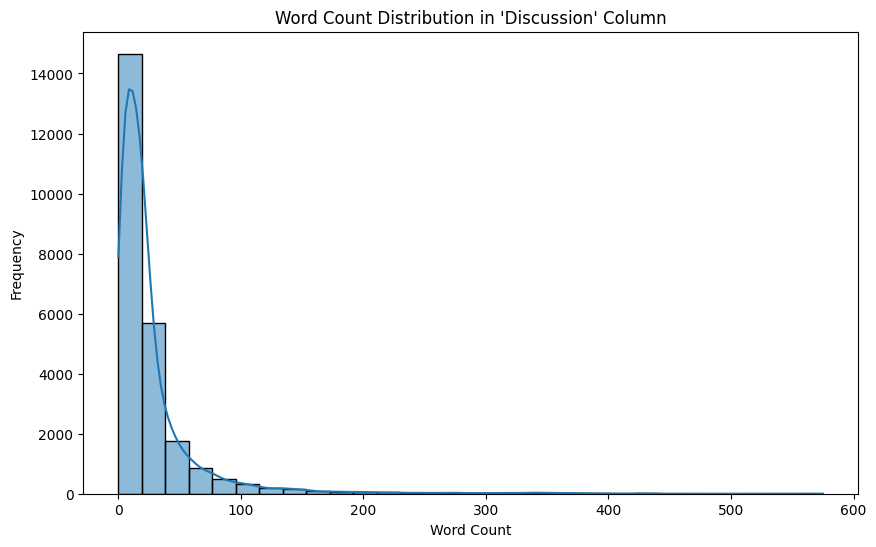

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(max_words_preprocessed, kde=True, bins=30)
plt.title("Word Count Distribution in 'Discussion' Column")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [112]:
# Summary statistics before filtering
print("Before removing outliers:")
print(max_words.describe())

# Summary statistics after filtering
filtered_max_words = data_filtered['Discussion'].str.split().str.len()
print("After removing outliers:")
print(filtered_max_words.describe())


Before removing outliers:
count    24646.000000
mean        49.919460
std         74.045042
min          1.000000
25%         13.000000
50%         29.000000
75%         54.000000
max        783.000000
Name: Discussion, dtype: float64
After removing outliers:
count    22295.000000
mean        17.361920
std         14.939438
min          0.000000
25%          6.000000
50%         14.000000
75%         23.000000
max        391.000000
Name: Discussion, dtype: float64


In [113]:
# Keep a backup of the original data (optional)
data_backup = data.copy()

# Replace the original data with the filtered data
data = data_filtered
data.head()

,SampleID,Discussion,Category
0,1,sit manually try scheduling software download ...,1
1,2,search end link,4
2,3,program compatible dvd rom drive s possibility...,4
5,6,wonder webcam run,2
6,7,read book feel excitement chill backbone act r...,2


In [114]:
# Split dataset into training and validation sets
train_data = data.sample(frac=0.85, random_state=42)
val_data = data.drop(train_data.index)

In [115]:
print(train_data["Category"].value_counts())
print("---")
val_data["Category"].value_counts()

Category
1    4323
3    4218
4    4128
2    3344
0    2938
Name: count, dtype: int64
---


Category
4    808
1    805
3    705
2    516
0    510
Name: count, dtype: int64

In [116]:
# Count unique words in the 'Discussion' column
unique_words = set(" ".join(data["Discussion"]).split())  # Using set to get unique words

# Print the number of unique words
print(f"Number of unique words: {len(unique_words)}")

# Now calculate the max tokens (max number of words in any 'Discussion' entry)
max_tokens = data['Discussion'].str.split().str.len().max()

print(f"Max tokens needed based on unique words: {max_tokens}")


Number of unique words: 34290
Max tokens needed based on unique words: 391


In [117]:
vectorizer = layers.TextVectorization(
    max_tokens=5000,  # 5000 based on data distribution
    output_sequence_length=30  
)
vectorizer.adapt(data_filtered["Discussion"])

# Check vocabulary size after vectorizer adaption
vocab_size = len(vectorizer.get_vocabulary())
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 5000


In [118]:
model = keras.models.Sequential()

# Input layer for raw text data
model.add(keras.layers.Input(shape=(), dtype=tf.string))

# Text vectorization layer
model.add(vectorizer)

# Embedding layer
model.add(keras.layers.Embedding(len(vectorizer.get_vocabulary()), 100))

# First Transformer encoder layer
model.add(
    keras_nlp.layers.TransformerEncoder(
        intermediate_dim=256,  # Capacity of the model
        num_heads=4,
        dropout=0.4  # Regularization
    )
)

# Second Transformer encoder layer
model.add(
    keras_nlp.layers.TransformerEncoder(
        intermediate_dim=256,
        num_heads=4,
        dropout=0.4
    )
)

# Global pooling
model.add(keras.layers.GlobalAveragePooling1D())

# Fully connected layers
model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# Output layer for 5-class classification
model.add(keras.layers.Dense(5, activation='softmax'))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_3                 │ (None, 30)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 30, 100)             │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_6                │ (None, 30, 100)             │          92,356 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_7                │ (None, 30, 100)             │          92,356 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706,989 (2.70 MB)

 Trainable params: 706,605 (2.70 MB)

 Non-trainable params: 384 (1.50 KB)

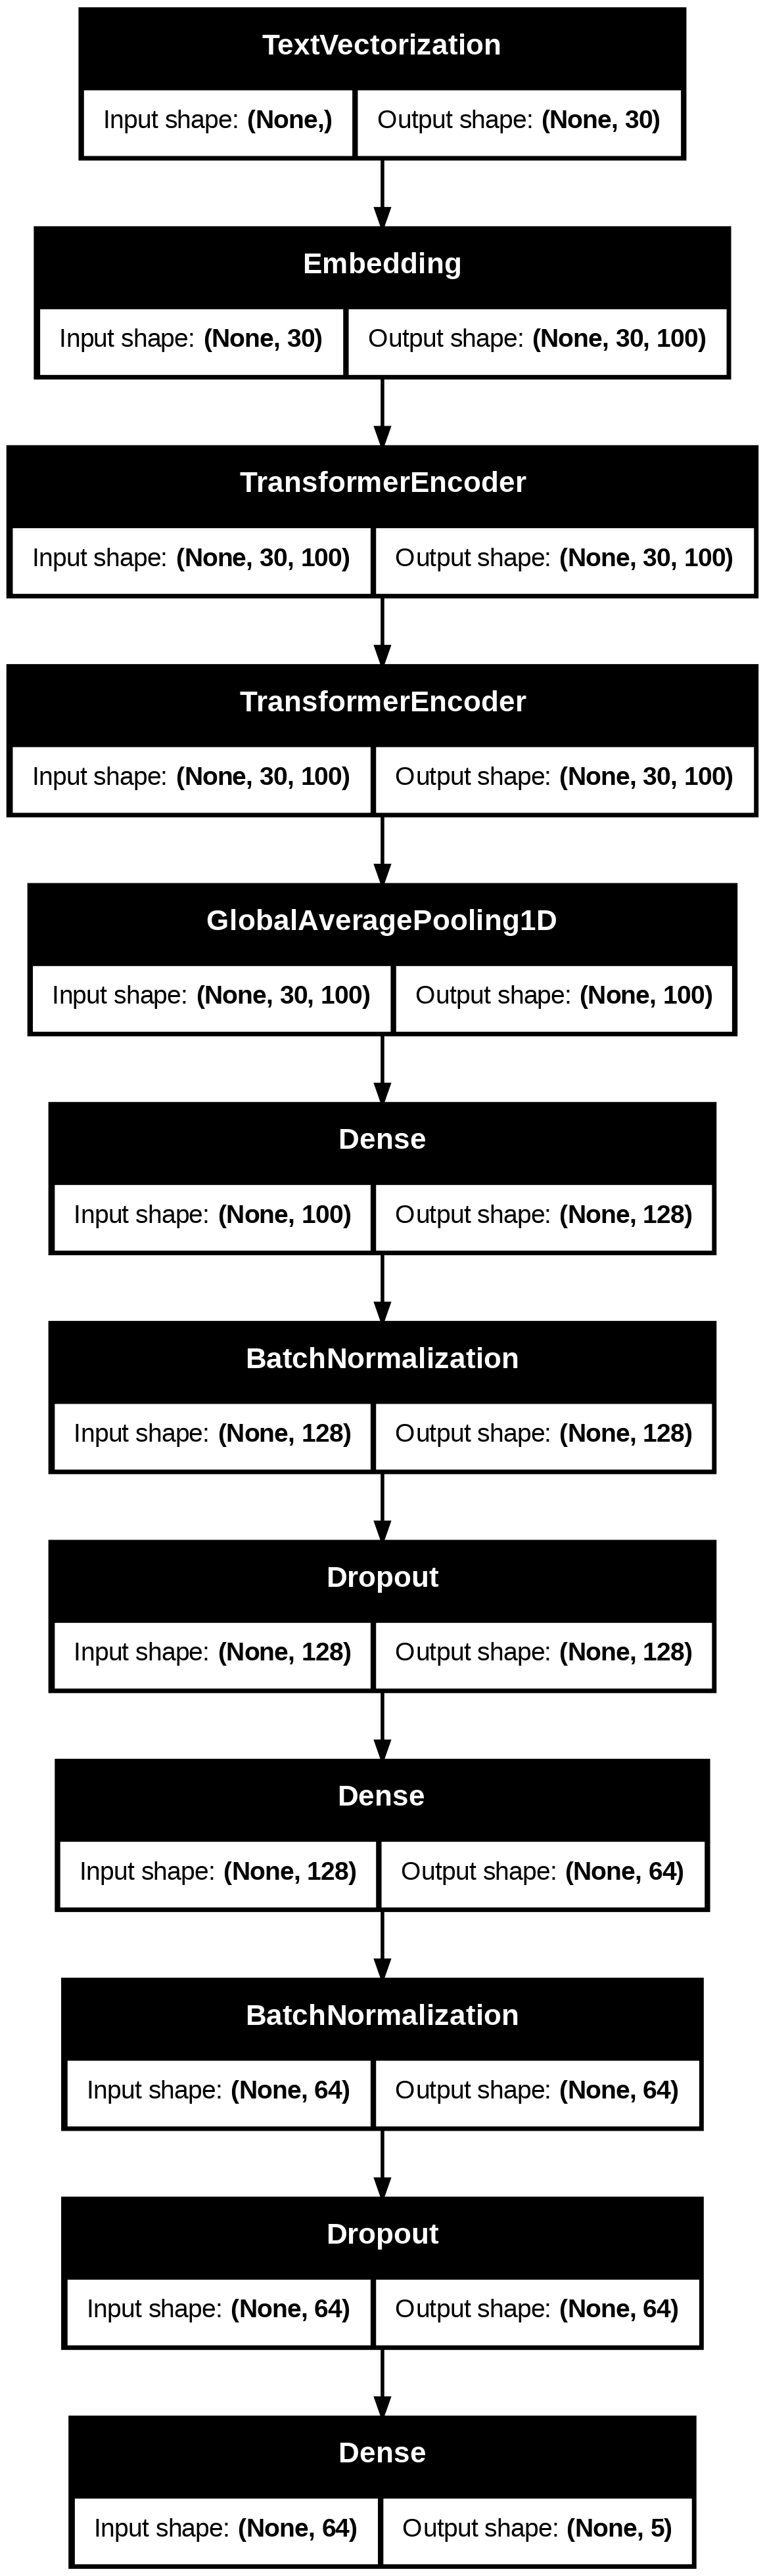

In [119]:
# Compile the model with custom optimizer and learning rate
from tensorflow.keras.optimizers import AdamW
messi = AdamW(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=messi, metrics=['accuracy'])

# Display model summary and architecture
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [120]:
# Prepare the dataset
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["Discussion"], train_data["Category"]))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data["Discussion"], val_data["Category"]))
val_dataset = val_dataset.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)

# Learning rate scheduler
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {accuracy:.2f}")

# Define the directory and file path
directory = "saved_model"
model_save_path = os.path.join(directory, "my_transformer_model.h5")

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2255 - loss: 4.4437 - val_accuracy: 0.2566 - val_loss: 3.5430 - learning_rate: 1.0000e-04
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2597 - loss: 4.0591 - val_accuracy: 0.4031 - val_loss: 3.2719 - learning_rate: 1.0000e-04
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3101 - loss: 3.7176 - val_accuracy: 0.4901 - val_loss: 3.0337 - learning_rate: 1.0000e-04
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3620 - loss: 3.4629 - val_accuracy: 0.5616 - val_loss: 2.8211 - learning_rate: 1.0000e-04
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4318 - loss: 3.1807 - val_accuracy: 0.5757 - val_loss: 2.7302 - learning_rate: 1.0000e-04
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4876 - loss: 2.9736 - val_accuracy: 0.5697 - val_loss: 2.6997 - learning_rate: 1.0000e-04
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc

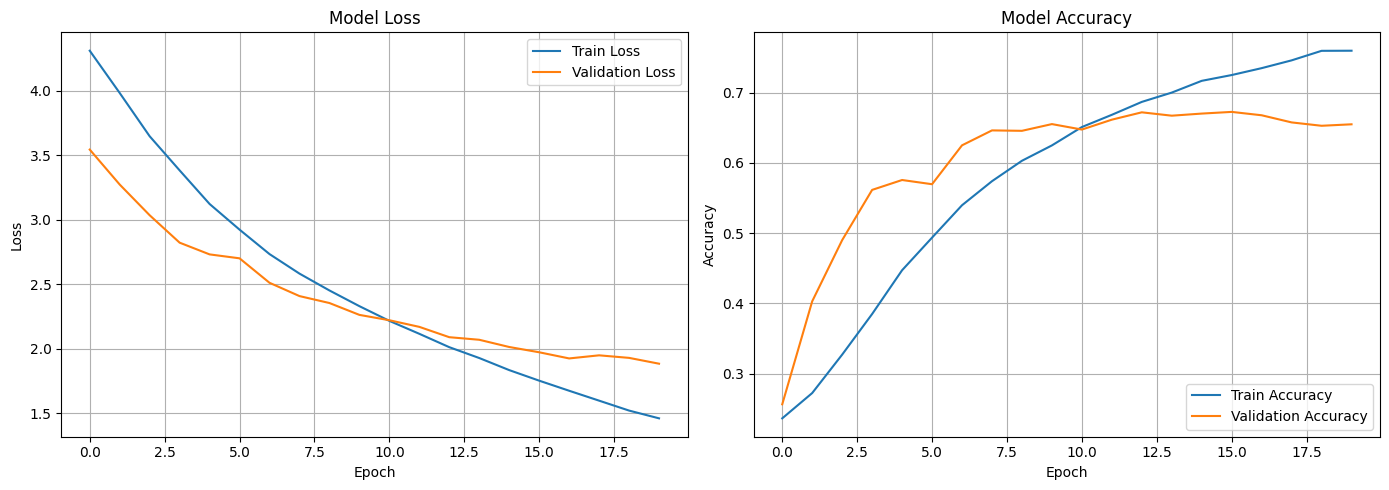

In [121]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history returned by model.fit()
# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Precision: 0.6704
Recall: 0.6549


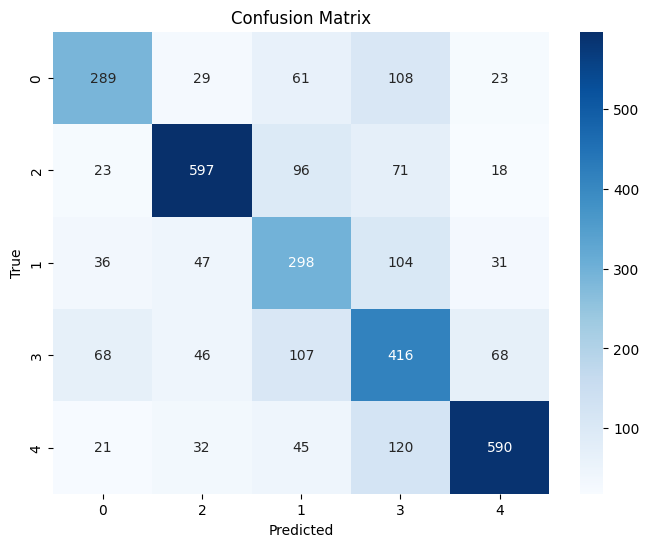

In [122]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

val_predictions = model.predict(val_dataset)
val_predictions = np.argmax(val_predictions, axis=1)  # If it's a classification problem with one-hot encoding

# Get the true labels from the validation set
val_true_labels = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

# Generate confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)

# Calculate precision and recall
precision = precision_score(val_true_labels, val_predictions, average='weighted')  # You can also use 'micro' or 'macro'
recall = recall_score(val_true_labels, val_predictions, average='weighted')  # You can also use 'micro' or 'macro'

# Print precision and recall
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data['Category'].unique(), yticklabels=train_data['Category'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [123]:
#testing 
test_data = pd.read_csv("/kaggle/input/dataset/test.csv")
test_data.head(5)

,SampleID,Discussion
0,1,Managing cash flow effectively is crucial for ...
1,2,Civic engagement plays a key role in a democra...
2,3,Proper warm-ups and cool-downs are essential t...
3,4,Data security is a growing concern as more peo...
4,5,"Investing in stocks can be risky, but with car..."


In [124]:
test_data['Discussion'] = test_data['Discussion'].apply(preprocess)

In [125]:
test_predictions = model.predict(test_data['Discussion'])
test_predictions = np.argmax(test_predictions, axis=1)  

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [126]:
result = pd.DataFrame({
    "SampleID": test_data["SampleID"].values,
    "Category": test_predictions
})

result.head(5)
result.to_csv('/kaggle/working/output.csv', index=False)

In [127]:
# Create a DataFrame with columns for SampleID and predictions
result = pd.DataFrame({
    "SampleID": test_data["SampleID"].values,
    "Category": test_predictions
})

# Display the first 5 rows of the result
result.head(5)

,SampleID,Category
0,1,3
1,2,0
2,3,1
3,4,3
4,5,3


In [128]:
print(test_data.columns)

Index(['SampleID', 'Discussion'], dtype='object')
